In [1]:
import numpy as np
import scipy as sp
import sympy as smp

from sympy import Matrix
from scipy.integrate import fixed_quad
from numpy.linalg import inv

In [2]:
# L2 Element
## Shape Functions ##
N0_L2 = lambda x: (1 - x)/2
N1_L2 = lambda x: (1 + x)/2

## Shape Function Derivatives ##
N0_D_L2 = lambda x: -1/2
N1_D_L2 = lambda x: 1/2

## Jacobian ##
J_L2 = lambda x, x1, x2: N0_D_L2(x)*x1 + N1_D_L2(x)*x2

## Isoparametric-to-Physical Converter ##
x_L2 = lambda x, x1, x2: N0_L2(x)*x1 + N1_L2(x)*x2

# L3 Element
## Shape Functions ##
N0_L3 = lambda x: 0.5*(x**2 - x)
N1_L3 = lambda x: 1 - x**2
N2_L3 = lambda x: 0.5*(x**2 + x)

## Shape Function Derivatives ##
N0_D_L3 = lambda x: x - 0.5
N1_D_L3 = lambda x: -2*x
N2_D_L3 = lambda x: x + 0.5  

## Jacobian ##
J_L3 = lambda x, x1, x2, x3: N0_D_L3(x)*x1 + N1_D_L3(x)*x2 + N2_D_L3(x)*x3

## Isoparametric-to-Physical Converter ##
x_L3 = lambda x, x1, x2, x3: N0_L3(x)*x1 + N1_L3(x)*x2 + N2_L3(x)*x3



N_L2 = [N0_L2, N1_L2]
N_D_L2 = [N0_D_L2, N1_D_L2]


N_L3 = [N0_L3, N1_L3, N2_L3]
N_D_L3 = [N0_D_L3, N1_D_L3, N2_D_L3]


In [3]:
x = smp.Symbol("x")
x_ = []
for i in range(1, 4):
    x_.append(smp.Symbol(f"x_{i}"))

N0d_L2 = x - 0.5
N1d_L2 = -2*x
N2d_L2 = x + 0.5

J = N0d_L2*x_[0] + N1d_L2*x_[1] + N2d_L2*x_[2]
display(J.expand())

x*x_1 - 2*x*x_2 + x*x_3 - 0.5*x_1 + 0.5*x_3

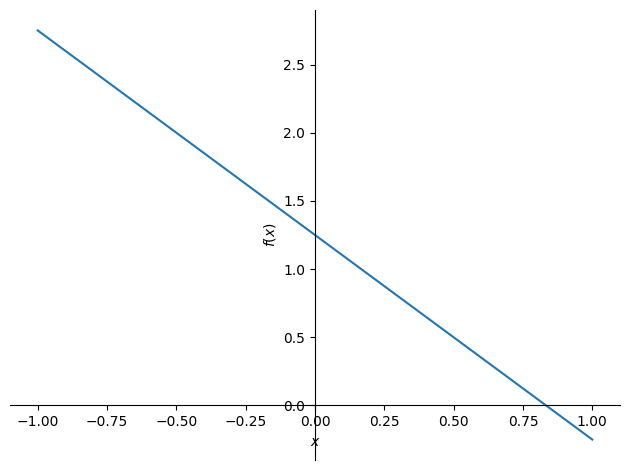

In [4]:
J = J.subs([(x_[0], 0), (x_[1], 2), (x_[2], 2.5)])
smp.plotting.plot(J, (x, -1, 1))

In [5]:
# ODE Integrands
def k_ij_L2(x1, x2, A, B):
    return_array = np.zeros((2, 2))
    # Assemble the integrand here
    for i in [0, 1]:
        for j in [0, 1]:
            integrand = lambda x: N_D_L2[i](x)*N_D_L2[j](x)*(1/J_L2(x, x1, x2)) + A*N_L2[i](x)*N_D_L2[j](x) + B*N_L2[i](x)*N_L2[j](x)*J_L2(x, x1, x2)
            return_array[i, j] += fixed_quad(integrand, -1, 1, n=9)[0]

    return return_array

def f_i_L2(x1, x2, driving_func):
    return_array = np.zeros(2)
    for i in [0, 1]:
        integrand = lambda x: driving_func(x_L2(x, x1, x2))*N_L2[i](x)*J_L2(x, x1, x2)
        return_array[i] += fixed_quad(integrand, -1, 1, n=9)[0]

    return return_array

def k_ij_L3(x1, x2, x3, A, B):
    return_array = np.zeros((3, 3))
    # Assemble the integrand here
    for i in [0, 1, 2]:
        for j in [0, 1, 2]:
            integrand = lambda x: N_D_L3[i](x)*N_D_L3[j](x)*(1/J_L3(x, x1, x2, x3)) + A*N_L3[i](x)*N_D_L3[j](x) + B*N_L3[i](x)*N_L3[j](x)*J_L3(x, x1, x2, x3)
            return_array[i, j] += fixed_quad(integrand, -1, 1, n=10)[0]

    return return_array

def f_i_L3(x1, x2, x3, driving_func):
    return_array = np.zeros(3)
    for i in [0, 1, 2]:
        integrand = lambda x: driving_func(x_L3(x, x1, x2, x3))*N_L3[i](x)*J_L3(x, x1, x2, x3)
        return_array[i] += fixed_quad(integrand, -1, 1, n=10)[0]

    return return_array
            

In [6]:
# Helper Functions
def output_array(filename, array):
    size = array.shape[0]
    # Determine if the array is a vector or matrix
    if len(array.shape) == 2:
        f = open(filename, "w")
        for i in range(size):
            for j in range(size):
                f.write(f"{array[i, j]}")
                f.write("\n")
        f.close()
    elif len(array.shape) == 1:
        f = open(filename, "w")
        for i in range(size):
            f.write(f"{array[i]}")
            f.write("\n")

        f.close()

def output_array_binary(filename, array):
    with open(filename, "wb") as f:
        array.tofile(f)
        

## Output Test Matrices and Vectors

In [7]:
linear_mesh = [0, 2.3, 3, 5.5, 10]
A = 4
B = 4
g = lambda x: x**2 + x + 3

K_list = []
F_list = []

for i in range(1, 5):
    x1 = linear_mesh[i - 1]
    x2 = linear_mesh[i]

    print(f"Element {i}")
    K_m = k_ij_L2(x1, x2, A, B)
    F_v = f_i_L2(x1, x2, g)

    """ Deprecated
    output_array(f"./test/integration/test_reference_array/L2/linear_matrix_{i}.txt", K_m)
    output_array(f"./test/integration/test_reference_array/L2/linear_vector_{i}.txt", F_v)
    """

    display(Matrix(K_m))
    display(Matrix(F_v))
    
    K_list.append(K_m)
    F_list.append(F_v)

Element 1


Matrix([
[  1.50144927536232, 3.09855072463768],
[-0.901449275362319, 5.50144927536232]])

Matrix([
[5.34558333333333],
[8.25508333333333]])

Element 2


Matrix([
[0.361904761904762, 1.03809523809524],
[-2.96190476190476, 4.36190476190476]])

Matrix([
[4.19241666666667],
[4.70691666666667]])

Element 3


Matrix([
[  1.73333333333333, 3.26666666666667],
[-0.733333333333333, 5.73333333333333]])

Matrix([
[        27.34375],
[37.2395833333333]])

Element 4


Matrix([
[ 4.22222222222222, 4.77777777777778],
[0.777777777777778, 8.22222222222222]])

Matrix([
[135.28125],
[190.96875]])

In [8]:
size = len(linear_mesh)
K_global = np.zeros((size, size), dtype = np.float64)
F_global = np.zeros(size, dtype = np.float64)

for i in range(4):
    index = i + 1
    K_global[index - 1:index + 1, index - 1:index + 1] += K_list[i]
    F_global[index - 1:index + 1] += F_list[i]

display(Matrix(K_global))
display(Matrix(F_global))

output_array_binary("./test/integration/test_reference_array/linear_matrix_global.output", K_global)
output_array_binary("./test/integration/test_reference_array/linear_vector_global.output", F_global)

Matrix([
[  1.50144927536232,  3.09855072463768,                0.0,               0.0,              0.0],
[-0.901449275362319,  5.86335403726708,   1.03809523809524,               0.0,              0.0],
[               0.0, -2.96190476190476,   6.09523809523809,  3.26666666666667,              0.0],
[               0.0,               0.0, -0.733333333333333,  9.95555555555555, 4.77777777777778],
[               0.0,               0.0,                0.0, 0.777777777777778, 8.22222222222222]])

Matrix([
[5.34558333333333],
[         12.4475],
[32.0506666666667],
[172.520833333333],
[       190.96875]])

In [9]:
# Get solution vector
# Set the boundary conditions
d1 = 0
d2 = 5
K_global[0, :] = 0
K_global[-1, :] = 0
K_global[0, 0] = 1
K_global[-1, -1] = 1

F_global[0] = d1
F_global[-1] = d2

solution_vector = inv(K_global)@F_global
display(Matrix(solution_vector))
output_array_binary("./test/integration/test_reference_array/linear_solution_vector.output", solution_vector)

Matrix([
[              0.0],
[ 2.39213937498745],
[-1.52053492214693],
[ 14.8175443026097],
[              5.0]])

In [10]:
quadratic_mesh = [0, 1.25, 2.5, 3, 6, 6.8, 7, 8.5, 10]
A = 4
B = 4
g = lambda x: x**2 + x + 3

K_list = []
F_list = []

for i in range(2, 9, 2):
    x1 = quadratic_mesh[i - 2]
    x2 = quadratic_mesh[i - 1]
    x3 = quadratic_mesh[i]

    index = int((i - 2)/2 + 1)

    print(f"Element {index}")
    K_m = k_ij_L3(x1, x2, x3, A, B)
    F_v = f_i_L3(x1, x2, x3, g)

    """ Deprecated
    output_array(f"./test/integration/test_reference_array/L3/quad_matrix_{index}.txt", K_m)
    output_array(f"./test/integration/test_reference_array/L3/quad_vector_{index}.txt", F_v)
    """
  
    display(Matrix(K_m))
    display(Matrix(F_v))

    K_list.append(K_m)
    F_list.append(F_v)


Element 1


Matrix([
[0.266666666666666,  2.26666666666666, -0.866666666666666],
[-3.06666666666667,  7.46666666666667,   2.26666666666667],
[0.466666666666663, -3.06666666666666,   4.26666666666666]])

Matrix([
[0.98958333333333],
[10.2083333333333],
[4.63541666666666]])

Element 2


Matrix([
[ 3.37111207975426, -3.82185298193552, -0.549259097818735],
[-9.15518631526885,  14.5699395900359,   3.91858005856631],
[0.784074235514595, -1.41475327476702,   6.29734570591908]])

Matrix([
[-6.67886904761904],
[ 50.2416666666667],
[ 48.6038690476189]])

Element 3


Matrix([
[-0.777932455142293,  7.20966227571146,  -4.9650631539025],
[  1.87632894237813, -17.6483113785573,  18.4386491028458],
[ -3.63172982056917,  13.1053157695125, -9.60691928227664]])

Matrix([
[ 17.6165904761904],
[ 35.6670476190476],
[-1.45030476190476]])

Element 4


Matrix([
[0.377777777777777,  2.57777777777777, -0.955555555555555],
[-2.75555555555556,  8.17777777777778,   2.57777777777778],
[0.377777777777775, -2.75555555555555,   4.37777777777777]])

Matrix([
[           29.05],
[           168.4],
[56.0499999999998]])

In [11]:
size = len(quadratic_mesh)
K_global = np.zeros((size, size), dtype = np.float64)
F_global = np.zeros(size, dtype = np.float64)

for i in range(2, size, 2):
    index = 2*i + 1
    K_global[i - 2:i + 1, i - 2:i + 1] += K_list[(i - 1)//2]
    F_global[i - 2:i + 1] += F_list[(i - 1)//2]

display(Matrix(K_global))
display(Matrix(F_global))

output_array_binary("./test/integration/test_reference_array/quad_matrix_global.output", K_global)
output_array_binary("./test/integration/test_reference_array/quad_vector_global.output", F_global)

Matrix([
[0.266666666666666,  2.26666666666666, -0.866666666666666,               0.0,                0.0,               0.0,               0.0,               0.0,                0.0],
[-3.06666666666667,  7.46666666666667,   2.26666666666667,               0.0,                0.0,               0.0,               0.0,               0.0,                0.0],
[0.466666666666663, -3.06666666666666,   7.63777874642091, -3.82185298193552, -0.549259097818735,               0.0,               0.0,               0.0,                0.0],
[              0.0,               0.0,  -9.15518631526885,  14.5699395900359,   3.91858005856631,               0.0,               0.0,               0.0,                0.0],
[              0.0,               0.0,  0.784074235514595, -1.41475327476702,   5.51941325077679,  7.20966227571146,  -4.9650631539025,               0.0,                0.0],
[              0.0,               0.0,                0.0,               0.0,   1.87632894237813, -17.648311378

Matrix([
[ 0.98958333333333],
[ 10.2083333333333],
[-2.04345238095239],
[ 50.2416666666667],
[ 66.2204595238093],
[ 35.6670476190476],
[ 27.5996952380952],
[            168.4],
[ 56.0499999999998]])

In [16]:
# Get solution vector
# Set the boundary conditions
d1 = 0
d2 = 5
K_global[0, :] = 0
K_global[-1, :] = 0
K_global[0, 0] = 1
K_global[-1, -1] = 1

F_global[0] = d1
F_global[-1] = d2

solution_vector = inv(K_global)@F_global
display(Matrix(solution_vector))
output_array_binary("./test/integration/test_reference_array/quad_solution_vector.output", solution_vector)

float64


Matrix([
[1.85304767131159e-16],
[   0.859418610562531],
[    1.67265045932343],
[    1.68267660080621],
[    10.4728233761783],
[    5.61507118586266],
[    6.24303386157572],
[    21.1199353229223],
[                 5.0]])

In [13]:
for func, input_v in zip(N_L3, [-0.43, -0.99, 0.48]):
    foo = func(input_v)
    print(foo)

0.30745
0.01990000000000003
0.35519999999999996


In [14]:
for func, input_v in zip(N_D_L3, [0.13, -0.13, 0.57]):
    foo = func(input_v)
    print(foo)

-0.37
0.26
1.0699999999999998


In [15]:
foo = J_L3(-0.07, 6, 6.8, 7)
bar = x_L3(0.1, 6, 6.8, 7)

print(foo)
print(bar)

0.5419999999999994
6.8469999999999995
